In [1]:
import pandas as pd

# Load the uploaded Excel file to check its structure
file_path = '../dataset/rab107row.xlsx'
data = pd.read_excel(file_path)

# Display the first few rows to understand the structure
data.head()

,namaproyek,rab,waktu,provinsi,tahun,luas,subitem,tinggi,lantai,ikk,ihbp,inflasi
0,Gedung Apartemen,2.641914e+10,196,Jawa Barat,2019,17401.00,4,21.8,6,103.03,143.72,3.21
1,Gedung Apartemen,8.821079e+10,273,DKI Jakarta,2022,16320.59,6,47.6,14,121.48,107.66,4.21
2,Gedung Apartemen,8.171200e+10,348,DKI Jakarta,2023,23688.00,5,34.0,10,116.73,113.88,2.28
3,Gedung Apartemen,3.690000e+11,830,Banten,2021,55000.00,6,49.8,16,97.64,109.64,1.91
4,Gedung Apartemen,5.400316e+11,700,DKI Jakarta,2023,150000.00,6,105.0,30,116.73,113.88,2.28


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor, RandomForestRegressor, StackingRegressor, VotingRegressor
from sklearn.linear_model import BayesianRidge, Lasso, LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

In [3]:
import numpy as np

numerical_columns = data.select_dtypes(include=['float64', 'int64']).columns

# Retry applying log transformation with numpy properly imported
transformed_data = data.copy()
for col in numerical_columns:
    transformed_data[col] = data[col].apply(lambda x: np.log1p(x) if x > 0 else x)

In [4]:
transformed_data.head()

,namaproyek,rab,waktu,provinsi,tahun,luas,subitem,tinggi,lantai,ikk,ihbp,inflasi
0,Gedung Apartemen,23.997354,5.283204,Jawa Barat,7.610853,9.764340,1.609438,3.126761,1.945910,4.644679,4.974801,1.437463
1,Gedung Apartemen,25.202995,5.613128,DKI Jakarta,7.612337,9.700244,1.945910,3.883624,2.708050,4.807948,4.688224,1.650580
2,Gedung Apartemen,25.126467,5.855072,DKI Jakarta,7.612831,10.072766,1.791759,3.555348,2.397895,4.768394,4.743888,1.187843
3,Gedung Apartemen,26.634062,6.722630,Banten,7.611842,10.915107,1.945910,3.927896,2.833213,4.591477,4.706282,1.068153
4,Gedung Apartemen,27.014893,6.552508,DKI Jakarta,7.612831,11.918397,1.945910,4.663439,3.433987,4.768394,4.743888,1.187843


In [5]:
cekduplikat = transformed_data[transformed_data.duplicated()]
cekduplikat

,namaproyek,rab,waktu,provinsi,tahun,luas,subitem,tinggi,lantai,ikk,ihbp,inflasi
22,Gedung Apartemen,26.146404,6.594413,Banten,7.611348,10.465096,1.791759,4.697293,3.465736,4.585478,4.650908,0.896088


In [6]:
transformed_data = transformed_data.drop_duplicates()

cekduplikat = transformed_data[transformed_data.duplicated()]
cekduplikat, transformed_data.shape

(Empty DataFrame
 Columns: [namaproyek, rab, waktu, provinsi, tahun, luas, subitem, tinggi, lantai, ikk, ihbp, inflasi]
 Index: [],
 (106, 12))

In [7]:
# Fungsi untuk mendeteksi outlier menggunakan metode IQR
def detect_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers, lower_bound, upper_bound

# Analisis outlier untuk setiap kolom numerik
outlier_results = {}
for col in numerical_columns:
    outliers, lower, upper = detect_outliers_iqr(transformed_data, col)
    outlier_results[col] = {
        "outliers_count": len(outliers),
        "lower_bound": lower,
        "upper_bound": upper
    }

# Menampilkan hasil analisis outlier
outlier_results

{'rab': {'outliers_count': 0,
  'lower_bound': 19.942509309324343,
  'upper_bound': 29.878975866310945},
 'waktu': {'outliers_count': 0,
  'lower_bound': 4.115594293821956,
  'upper_bound': 7.292699322311036},
 'tahun': {'outliers_count': 0,
  'lower_bound': 7.60788543037709,
  'upper_bound': 7.615798390425516},
 'luas': {'outliers_count': 0,
  'lower_bound': 4.626135712885208,
  'upper_bound': 13.50521030326389},
 'subitem': {'outliers_count': 24,
  'lower_bound': 1.5605334494871674,
  'upper_bound': 2.1771361687962005},
 'tinggi': {'outliers_count': 0,
  'lower_bound': 0.5451998640506068,
  'upper_bound': 6.24499765950352},
 'lantai': {'outliers_count': 0,
  'lower_bound': -0.6446193937132167,
  'upper_bound': 4.9199129867178755},
 'ikk': {'outliers_count': 1,
  'lower_bound': 4.459107497071852,
  'upper_bound': 4.953965689101057},
 'ihbp': {'outliers_count': 0,
  'lower_bound': 4.2583580911778816,
  'upper_bound': 5.404666491032535},
 'inflasi': {'outliers_count': 2,
  'lower_bound'

In [8]:
# Fungsi untuk mendeteksi dan menghapus baris yang mengandung outlier
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Hapus baris yang memiliki nilai outlier
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Hapus outlier untuk setiap kolom numerik
data_cleaned = transformed_data.copy()
for col in numerical_columns:
    data_cleaned = remove_outliers_iqr(data_cleaned, col)

In [9]:
data_cleaned.shape

(80, 12)

In [10]:
# Label encoding kolom 'Provinsi' dan nama proyek karena nilainya kategorikal
label_encoder = LabelEncoder()
data_cleaned['label_provinsi'] = label_encoder.fit_transform(data_cleaned['provinsi'])
data_cleaned['label_namaproyek'] = label_encoder.fit_transform(data_cleaned['namaproyek'])

# Melihat nilai unik dari hasil encoding kolom 'provinsi_encoded'
provinsi_unik = data_cleaned[['provinsi', 'label_provinsi']].drop_duplicates().sort_values(
    by='label_provinsi')

# Melihat nilai unik dari hasil encoding kolom 'namaproyek_encoded'
namaproyek_unik = data_cleaned[['namaproyek', 'label_namaproyek']].drop_duplicates().sort_values(
    by='label_namaproyek')

In [11]:
provinsi_unik

,provinsi,label_provinsi
95,Bali,0
3,Banten,1
1,DKI Jakarta,2
0,Jawa Barat,3
23,Jawa Tengah,4
59,Jawa Timur,5
66,Kalimantan Timur,6
55,Kepulauan Riau,7
25,Nusa Tenggara Barat,8
41,Papua,9


In [12]:
namaproyek_unik

,namaproyek,label_namaproyek
0,Gedung Apartemen,0
35,Gedung Asrama,1
43,Gedung Gudang,2
45,Gedung Hotel,3
49,Gedung Kampus,4
55,Gedung Kantor,5
76,Gedung Laboratorium,6
81,Gedung Olahraga,7
83,Gedung Pabrik,8
84,Gedung Parkir,9


In [13]:
# 4. Normalisasi Kolom Numerik
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

numerical_columns = ['waktu', 'tahun', 'luas', 'subitem', 
                     'tinggi', 'lantai', 'ikk', 'ihbp', 'inflasi']
# 4. Normalisasi Kolom Numerik
scalerMinMax = MinMaxScaler()
data_cleaned[numerical_columns] = scalerMinMax.fit_transform(data_cleaned[numerical_columns])

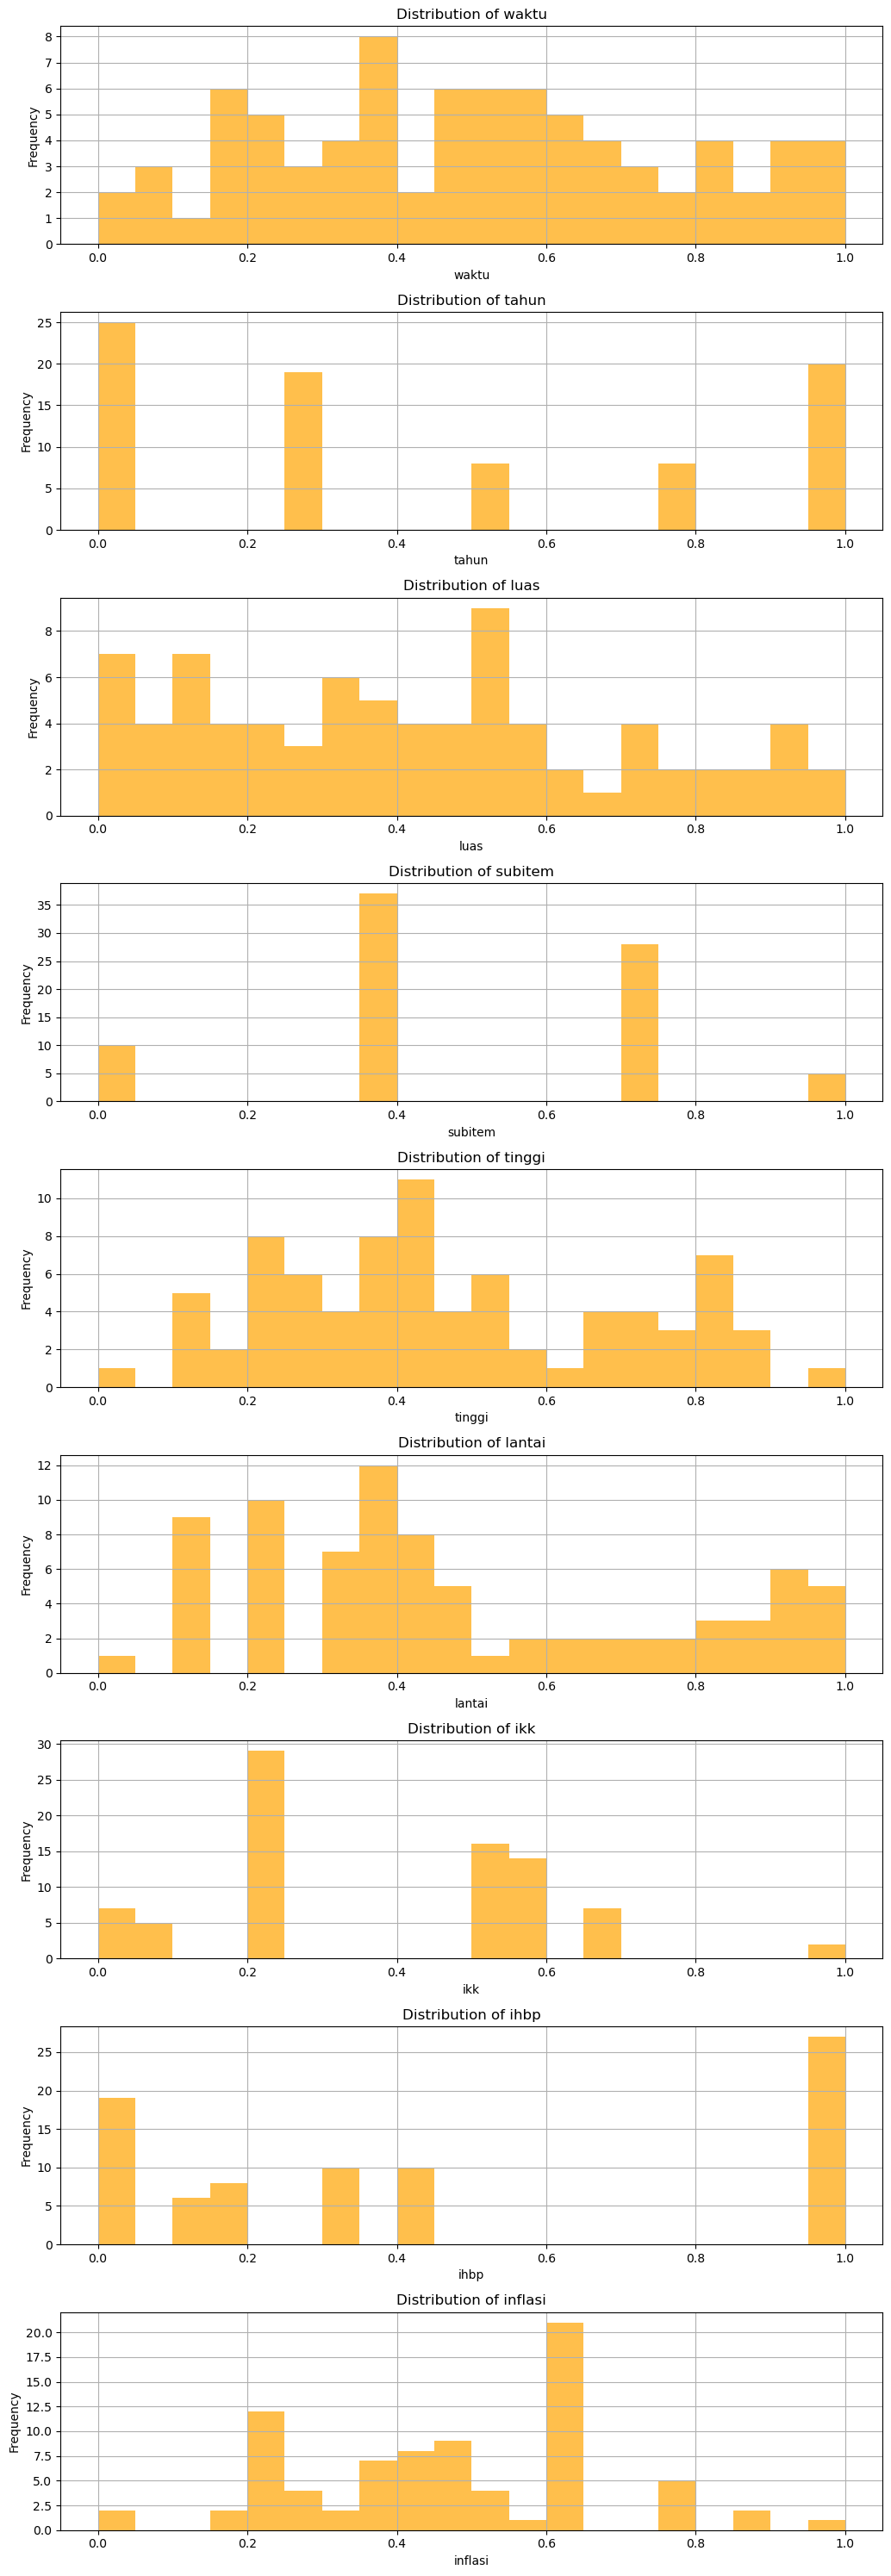

In [14]:
# Compare distributions before and after transformation using histograms
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 30))
for i, col in enumerate(numerical_columns, 1):

    # Transformed data
    plt.subplot(len(numerical_columns), 2, 2 * i)
    data_cleaned[col].hist(bins=20, alpha=0.7, color='orange')
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

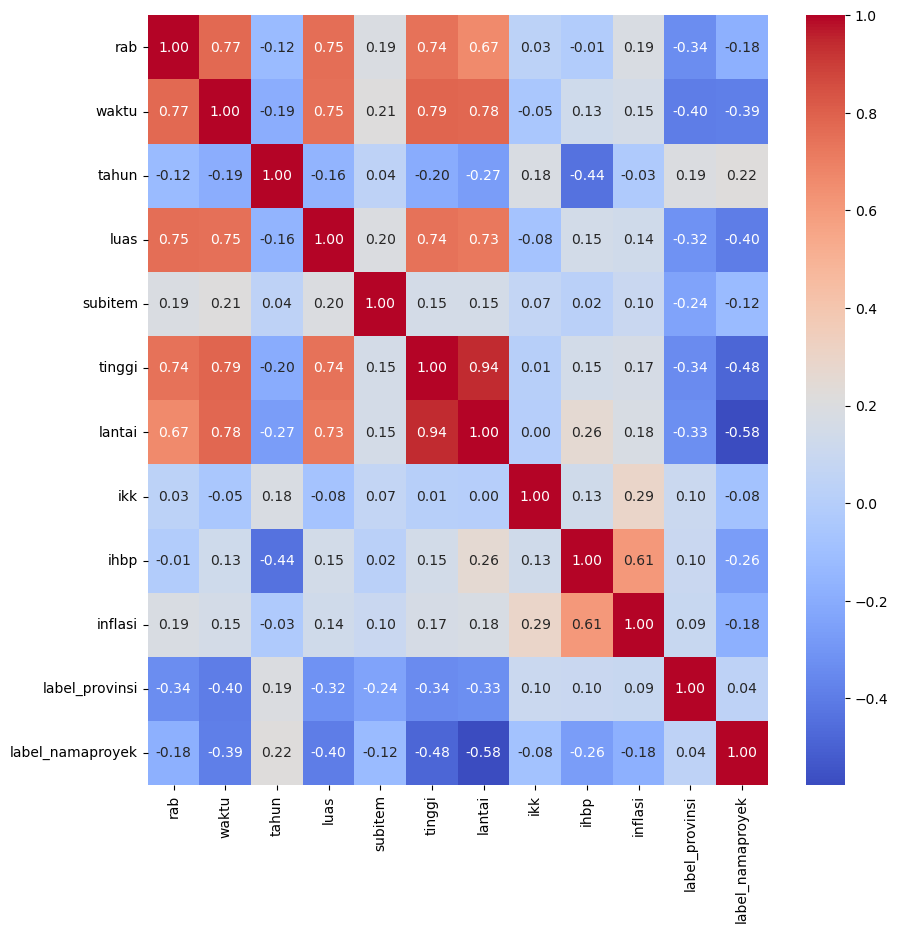

In [15]:
# Digunakan untuk membuat visualisasi dalam bentuk grafik atau plot
import seaborn as sns
import matplotlib.pyplot as plt
# Visualisasi korelasi antar fitur atau kolom apakah saling berpengaruh atau tidak
fig, ax = plt.subplots(figsize=(10,10))  
sns.heatmap(data_cleaned.corr(numeric_only=True), 
            annot=True, cmap='coolwarm', fmt='.2f', ax=ax)
plt.show()

In [16]:
# Split data into features and target
X1 = data_cleaned.drop(columns=[
    'rab', 'namaproyek', 'provinsi', 'lantai'])
y1 = data_cleaned['rab']

# Split into training and testing sets
X_train1, X_test1, y_train1, y_test1 = train_test_split(
    X1, y1, 
    test_size=0.3, 
    random_state=42)

# Split into training and testing sets
X_train2, X_test2, y_train2, y_test2 = train_test_split(
    X1, y1, 
    test_size=0.2, 
    random_state=42)

Stacking Regressor 70:30

In [17]:
from sklearn.pipeline import make_pipeline

# 2. Definisi model individual

rf = RandomForestRegressor(random_state=42)
ridge = Ridge(random_state=42)
xgboost = xgb.XGBRegressor()
br = BayesianRidge()
gb = GradientBoostingRegressor(random_state=42)
lr = LinearRegression()
adb = AdaBoostRegressor(random_state=42)


meta_model = Ridge(alpha=10, random_state=42)

# 3. Membuat Stacking Regressor
stacking_regressor = StackingRegressor(
   estimators=[
        ('rf', rf),
        ('adb', adb),
        ('ridge', ridge),
        ('gb', gb),
        ('br', br),
        # ('xgboost', xgboost),
        # ('lr', lr),
    ],
    final_estimator=meta_model)

# 4. Melatih Stacking Regressor
stacking_regressor.fit(X_train1, y_train1)

# Training
y_train_pred_stacking = stacking_regressor.predict(X_train1)
mae_train_stacking = mean_absolute_error(y_train1, y_train_pred_stacking)
rmse_train_stacking = np.sqrt(mean_squared_error(y_train1, y_train_pred_stacking))
r2_train_stacking = r2_score(y_train1, y_train_pred_stacking)

# Testing
y_test_pred_stacking = stacking_regressor.predict(X_test1)
mae_test_stacking = mean_absolute_error(y_test1, y_test_pred_stacking)
rmse_test_stacking = np.sqrt(mean_squared_error(y_test1, y_test_pred_stacking))
r2_test_stacking = r2_score(y_test1, y_test_pred_stacking)

print("Training")
print(f"Mean Absolute Error (MAE): ", "{:.3f}".format(mae_train_stacking))
print(f"Root Mean Squared Error (MSE): ", "{:.3f}".format(rmse_train_stacking))
print(f"R² Score: ", "{:.3f}".format(r2_train_stacking))
print("="*80)
print("Testing")
print(f"Mean Absolute Error (MAE): ", "{:.3f}".format(mae_test_stacking))
print(f"Root Mean Squared Error (MSE): ", "{:.3f}".format(rmse_test_stacking))
print(f"R² Score: ", "{:.3f}".format(r2_test_stacking))

Training
Mean Absolute Error (MAE):  0.555
Root Mean Squared Error (MSE):  0.698
R² Score:  0.815
Testing
Mean Absolute Error (MAE):  0.457
Root Mean Squared Error (MSE):  0.652
R² Score:  0.802


Voting Regressor 70:30

In [18]:
from sklearn.pipeline import make_pipeline

# 3. Membuat Voting Regressor
voting_regressor = VotingRegressor(
   estimators=[
        ('rf', rf),
        ('adb', adb),
        ('ridge', ridge),
        ('gb', gb),
        ('br', br),
        # ('xgboost', xgboost),
        # ('lr', lr),
    ])

# 4. Melatih Voting Regressor
voting_regressor.fit(X_train1, y_train1)

# Training
y_train_pred_voting = voting_regressor.predict(X_train1)
mae_train_voting = mean_absolute_error(y_train1, y_train_pred_voting)
rmse_train_voting = np.sqrt(mean_squared_error(y_train1, y_train_pred_voting))
r2_train_voting = r2_score(y_train1, y_train_pred_voting)

# Testing
y_test_pred_voting = voting_regressor.predict(X_test1)
mae_test_voting = mean_absolute_error(y_test1, y_test_pred_voting)
rmse_test_voting = np.sqrt(mean_squared_error(y_test1, y_test_pred_voting))
r2_test_voting = r2_score(y_test1, y_test_pred_voting)

print("Training")
print(f"Mean Absolute Error (MAE): ", "{:.3f}".format(mae_train_voting))
print(f"Root Mean Squared Error (MSE): ", "{:.3f}".format(rmse_train_voting))
print(f"R² Score: ", "{:.3f}".format(r2_train_voting))
print("="*80)
print("Testing")
print(f"Mean Absolute Error (MAE): ", "{:.3f}".format(mae_test_voting))
print(f"Root Mean Squared Error (MSE): ", "{:.3f}".format(rmse_test_voting))
print(f"R² Score: ", "{:.3f}".format(r2_test_voting))

Training
Mean Absolute Error (MAE):  0.373
Root Mean Squared Error (MSE):  0.456
R² Score:  0.921
Testing
Mean Absolute Error (MAE):  0.458
Root Mean Squared Error (MSE):  0.621
R² Score:  0.820


Stacking Regressor 80:20

In [19]:
from sklearn.pipeline import make_pipeline

# 2. Definisi model individual

rf2 = RandomForestRegressor(random_state=42)
ridge2 = Ridge(random_state=42)
xgboost2 = xgb.XGBRegressor()
br2 = BayesianRidge()
gb2 = GradientBoostingRegressor(random_state=42)
lr2 = LinearRegression()
adb2 = AdaBoostRegressor(random_state=42)
knn2 = KNeighborsRegressor()
svr2 = SVR()


meta_model2 = Ridge(alpha=10, random_state=42)

# 3. Membuat Stacking Regressor
stacking_regressor2 = StackingRegressor(
   estimators=[
        ('xgboost', xgboost2),
        ('ridge', ridge2),
        ('rf', rf2),
        # ('br', br2),
        # ('gb', gb2),
        # ('lr', lr2),
        # ('adb', adb2),
        # ('KNN', knn2),
        # ('SVR', svr2),
    ],
    final_estimator=meta_model2)

# 4. Melatih Stacking Regressor
stacking_regressor2.fit(X_train2, y_train2)

# Training
y_train_pred_stacking2 = stacking_regressor2.predict(X_train2)
mae_train_stacking2 = mean_absolute_error(y_train2, y_train_pred_stacking2)
rmse_train_stacking2 = np.sqrt(mean_squared_error(y_train2, y_train_pred_stacking2))
r2_train_stacking2 = r2_score(y_train2, y_train_pred_stacking2)

# Testing
y_test_pred_stacking2 = stacking_regressor2.predict(X_test2)
mae_test_stacking2 = mean_absolute_error(y_test2, y_test_pred_stacking2)
rmse_test_stacking2 = np.sqrt(mean_squared_error(y_test2, y_test_pred_stacking2))
r2_test_stacking2 = r2_score(y_test2, y_test_pred_stacking2)

print("Training")
print(f"Mean Absolute Error (MAE): ", "{:.3f}".format(mae_train_stacking2))
print(f"Root Mean Squared Error (MSE): ", "{:.3f}".format(rmse_train_stacking2))
print(f"R² Score: ", "{:.3f}".format(r2_train_stacking2))
print("="*80)
print("Testing")
print(f"Mean Absolute Error (MAE): ", "{:.3f}".format(mae_test_stacking2))
print(f"Root Mean Squared Error (MSE): ", "{:.3f}".format(rmse_test_stacking2))
print(f"R² Score: ", "{:.3f}".format(r2_test_stacking2))

Training
Mean Absolute Error (MAE):  0.462
Root Mean Squared Error (MSE):  0.601
R² Score:  0.856
Testing
Mean Absolute Error (MAE):  0.382
Root Mean Squared Error (MSE):  0.576
R² Score:  0.857


Voting Regressor 80:20

In [39]:
from sklearn.pipeline import make_pipeline

# 3. Membuat Voting Regressor
voting_regressor2 = VotingRegressor(
   estimators=[
        ('xgboost', xgboost2),
        ('ridge', ridge2),
        ('rf', rf2),
        # ('br', br2),
        # ('gb', gb2),
        # ('lr', lr2),
        # ('adb', adb2),
    ],
    weights=[3, 2, 1])

# 4. Melatih Voting Regressor
voting_regressor2.fit(X_train2, y_train2)

# Training
y_train_pred_voting2 = voting_regressor2.predict(X_train2)
mae_train_voting2 = mean_absolute_error(y_train2, y_train_pred_voting2)
rmse_train_voting2 = np.sqrt(mean_squared_error(y_train2, y_train_pred_voting2))
r2_train_voting2 = r2_score(y_train2, y_train_pred_voting2)

# Testing
y_test_pred_voting2 = voting_regressor2.predict(X_test2)
mae_test_voting2 = mean_absolute_error(y_test2, y_test_pred_voting2)
rmse_test_voting2 = np.sqrt(mean_squared_error(y_test2, y_test_pred_voting2))
r2_test_voting2 = r2_score(y_test2, y_test_pred_voting2)

print("Training")
print(f"Mean Absolute Error (MAE): ", "{:.3f}".format(mae_train_voting2))
print(f"Root Mean Squared Error (MSE): ", "{:.3f}".format(rmse_train_voting2))
print(f"R² Score: ", "{:.3f}".format(r2_train_voting2))
print("="*80)
print("Testing")
print(f"Mean Absolute Error (MAE): ", "{:.3f}".format(mae_test_voting2))
print(f"Root Mean Squared Error (MSE): ", "{:.3f}".format(rmse_test_voting2))
print(f"R² Score: ", "{:.3f}".format(r2_test_voting2))

Training
Mean Absolute Error (MAE):  0.244
Root Mean Squared Error (MSE):  0.317
R² Score:  0.960
Testing
Mean Absolute Error (MAE):  0.394
Root Mean Squared Error (MSE):  0.525
R² Score:  0.882


karena yang paling bagus selalu voting jadi ambilnya voting aja

Actual dan Prediksinya

In [21]:
# Prediksi nilai actual dan prediksi untuk 70:30
y_actual1 = y_test1
y_pred_best1 = voting_regressor.predict(X_test1)

# Prediksi nilai actual dan prediksi untuk 80:20
y_actual2 = y_test2
y_pred_best2 = voting_regressor2.predict(X_test2)

Voting Regressor 70:30

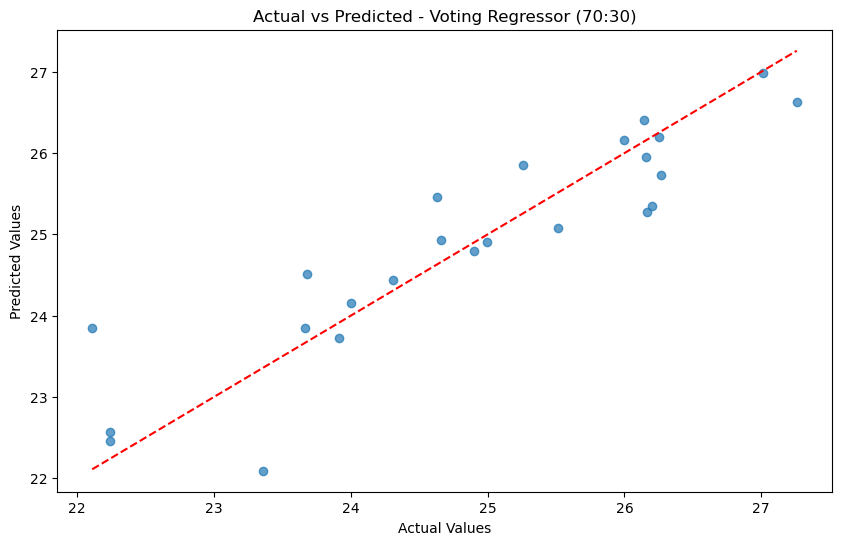

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(y_actual1, y_pred_best1, alpha=0.7)
plt.plot([y_actual1.min(), y_actual1.max()], [y_actual1.min(), y_actual1.max()], 'r--')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title(f"Actual vs Predicted - Voting Regressor (70:30)")
plt.show()


Voting Regressor 80:20

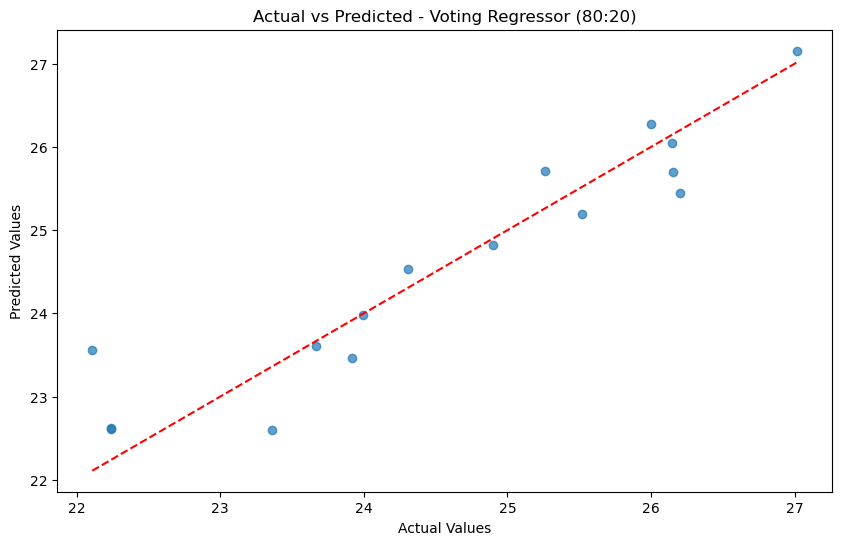

In [23]:
plt.figure(figsize=(10, 6))
plt.scatter(y_actual2, y_pred_best2, alpha=0.7)
plt.plot([y_actual2.min(), y_actual2.max()], [y_actual2.min(), y_actual2.max()], 'r--')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title(f"Actual vs Predicted - Voting Regressor (80:20)")
plt.show()


In [24]:
# Dataframe untuk 70:30
comparison1 = pd.DataFrame({'Actual': y_actual1, 'Predicted': y_pred_best1})

# Dataframe untuk 80:20
comparison2 = pd.DataFrame({'Actual': y_actual2, 'Predicted': y_pred_best2})

# Tampilkan beberapa baris pertama
print(comparison1.head())
print(comparison2.head())


       Actual  Predicted
38  23.357097  22.090811
0   23.997354  24.154135
27  26.199729  25.354297
39  22.237415  22.454495
21  26.146404  26.401900
       Actual  Predicted
38  23.357097  22.601988
0   23.997354  23.979067
27  26.199729  25.449127
39  22.237415  22.613211
21  26.146404  26.042815


In [25]:
# Kembalikan nilai log ke bentuk asli
comparison1['Actual (Original)'] = np.exp(comparison1['Actual'])
comparison1['Predicted (Original)'] = np.exp(comparison1['Predicted'])

comparison2['Actual (Original)'] = np.exp(comparison2['Actual'])
comparison2['Predicted (Original)'] = np.exp(comparison2['Predicted'])

# Format ke dalam Rupiah
def format_rupiah(value):
    return f"Rp {value:,.0f}".replace(",", ".")

comparison1['Actual (Rupiah)'] = comparison1['Actual (Original)'].apply(format_rupiah)
comparison1['Predicted (Rupiah)'] = comparison1['Predicted (Original)'].apply(format_rupiah)

comparison2['Actual (Rupiah)'] = comparison2['Actual (Original)'].apply(format_rupiah)
comparison2['Predicted (Rupiah)'] = comparison2['Predicted (Original)'].apply(format_rupiah)

# Tampilkan beberapa baris pertama
print(comparison1[['Actual (Rupiah)', 'Predicted (Rupiah)']])
print()
print("*" * 100)
print(comparison2[['Actual (Rupiah)', 'Predicted (Rupiah)']])


       Actual (Rupiah)  Predicted (Rupiah)
38   Rp 13.927.029.001    Rp 3.925.703.607
0    Rp 26.419.136.187   Rp 30.903.487.957
27  Rp 239.000.000.001  Rp 102.619.844.484
39    Rp 4.545.551.009    Rp 5.647.591.626
21  Rp 226.589.000.001  Rp 292.549.521.073
35    Rp 4.545.551.009    Rp 6.298.324.692
10  Rp 120.781.089.488   Rp 77.948.333.635
92  Rp 228.530.000.001  Rp 186.875.041.718
4   Rp 540.031.588.145  Rp 522.395.835.213
13  Rp 195.596.000.001  Rp 229.389.925.281
64   Rp 65.000.000.001   Rp 58.791.639.967
41   Rp 24.322.000.001   Rp 20.143.746.988
88   Rp 35.905.245.001   Rp 41.214.808.677
43   Rp 18.970.782.261   Rp 22.824.713.422
89   Rp 93.541.144.803  Rp 169.907.140.962
59    Rp 3.997.225.850   Rp 22.686.269.547
95  Rp 690.000.000.001  Rp 367.151.681.922
78   Rp 49.559.404.693  Rp 114.440.309.983
72  Rp 230.570.298.290   Rp 94.694.220.117
52  Rp 254.967.000.193  Rp 149.334.922.075
9   Rp 251.146.002.001  Rp 238.473.575.943
83   Rp 71.420.000.001   Rp 65.139.724.621
5    Rp 51.

Voting Regressor 1 70:30

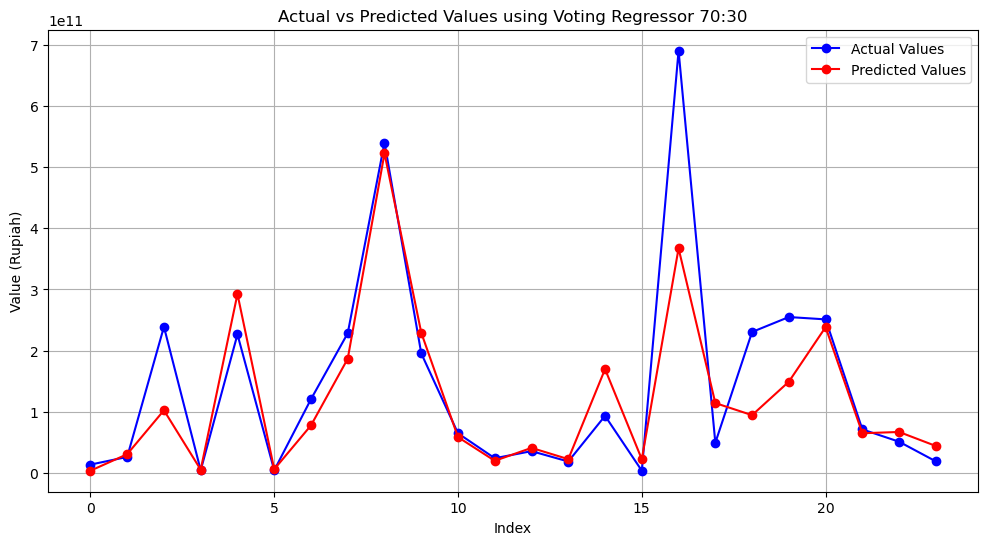

In [26]:
# Predict on the test data
y_pred_log1 = voting_regressor.predict(X_test1)

# If your target variable was log-transformed, revert it back
y_actual1 = np.exp(y_test1.reset_index(drop=True))
y_pred1 = np.exp(y_pred_log1)

# Create a DataFrame for comparison
comparison_df = pd.DataFrame({
    'Actual': y_actual1,
    'Predicted': y_pred1
})

# Plot Actual vs Predicted Values
plt.figure(figsize=(12, 6))
plt.plot(comparison_df.index, comparison_df['Actual'], 'bo-', label='Actual Values')
plt.plot(comparison_df.index, comparison_df['Predicted'], 'ro-', label='Predicted Values')
plt.xlabel('Index')
plt.ylabel('Value (Rupiah)')
plt.title(f'Actual vs Predicted Values using Voting Regressor 70:30')
plt.legend()
plt.grid(True)
plt.show()


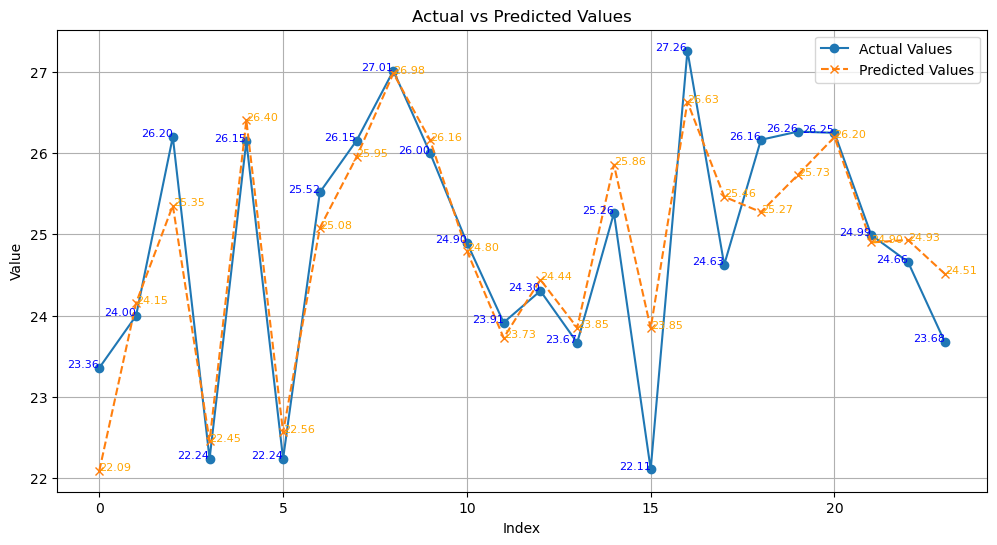

In [27]:
import matplotlib.pyplot as plt
import numpy as np

# Pastikan data berbentuk array (jika tidak, ubah dengan np.array)
y_test = np.array(y_test1)  # Nilai aktual
y_pred = np.array(y_pred_log1)  # Nilai prediksi

# Buat plot
plt.figure(figsize=(12, 6))
plt.plot(range(len(y_test)), y_test, label='Actual Values', marker='o', linestyle='-')
plt.plot(range(len(y_pred)), y_pred, label='Predicted Values', marker='x', linestyle='--')

# Tambahkan angka di setiap titik
for i, (y_actual, y_predict) in enumerate(zip(y_test, y_pred)):
    plt.text(i, y_actual, f'{y_actual:.2f}', fontsize=8, ha='right', color='blue')
    plt.text(i, y_predict, f'{y_predict:.2f}', fontsize=8, ha='left', color='orange')

# Tambahkan label dan judul
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.grid(True)

# Tampilkan plot
plt.show()

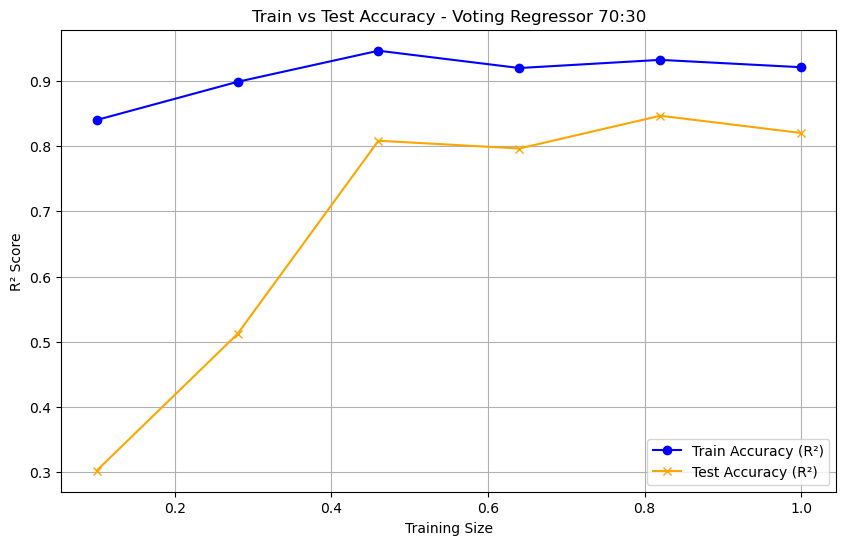

In [28]:
import numpy as np
import matplotlib.pyplot as plt

# Training sizes (misalnya dalam persen data training)
training_sizes = np.linspace(0.1, 1.0, 6)

# Menyimpan nilai R² untuk setiap training size
train_accuracies_best = []
test_accuracies_best = []

for size in training_sizes:
    # Tentukan jumlah data training sesuai ukuran
    train_size = int(size * len(X_train1))
    X_train_subset = X_train1[:train_size]
    y_train_subset = y_train1[:train_size]
    
    # Fit model dengan subset data
    voting_regressor.fit(X_train_subset, y_train_subset)
    
    # Prediksi untuk data training dan testing
    y_train_pred = voting_regressor.predict(X_train_subset)
    y_test_pred = voting_regressor.predict(X_test1)
    
    # Hitung R² Score
    train_accuracies_best.append(r2_score(y_train_subset, y_train_pred))
    test_accuracies_best.append(r2_score(y_test1, y_test_pred))

# Plot Train vs Test Accuracy khusus model terbaik
plt.figure(figsize=(10, 6))
plt.plot(training_sizes, train_accuracies_best, 'bo-', label='Train Accuracy (R²)')
plt.plot(training_sizes, test_accuracies_best, 'x-', color='orange', label='Test Accuracy (R²)')
plt.xlabel('Training Size')
plt.ylabel('R² Score')
plt.title(f'Train vs Test Accuracy - Voting Regressor 70:30')
plt.grid(True)
plt.legend()
plt.show()


Voting Regressor 2 80:20

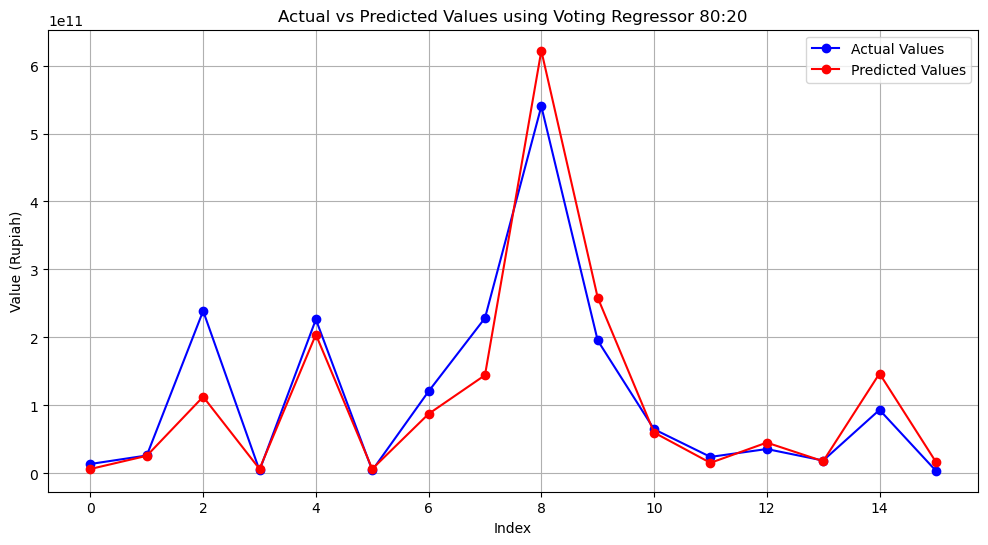

In [29]:
# Predict on the test data
y_pred_log2 = voting_regressor2.predict(X_test2)

# If your target variable was log-transformed, revert it back
y_actual2 = np.exp(y_test2.reset_index(drop=True))
y_pred2 = np.exp(y_pred_log2)

# Create a DataFrame for comparison
comparison_df = pd.DataFrame({
    'Actual': y_actual2,
    'Predicted': y_pred2
})

# Plot Actual vs Predicted Values
plt.figure(figsize=(12, 6))
plt.plot(comparison_df.index, comparison_df['Actual'], 'bo-', label='Actual Values')
plt.plot(comparison_df.index, comparison_df['Predicted'], 'ro-', label='Predicted Values')
plt.xlabel('Index')
plt.ylabel('Value (Rupiah)')
plt.title(f'Actual vs Predicted Values using Voting Regressor 80:20')
plt.legend()
plt.grid(True)
plt.show()


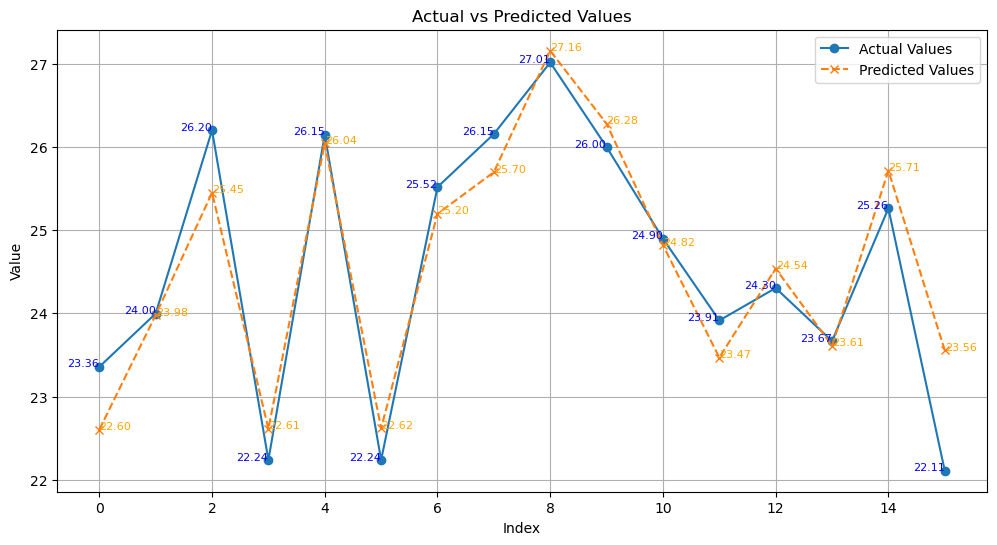

In [30]:
import matplotlib.pyplot as plt
import numpy as np

# Pastikan data berbentuk array (jika tidak, ubah dengan np.array)
y_test_voting2 = np.array(y_test2)  # Nilai aktual
y_pred_voting2 = np.array(y_pred_log2)  # Nilai prediksi

# Buat plot
plt.figure(figsize=(12, 6))
plt.plot(range(len(y_test_voting2)), y_test_voting2, label='Actual Values', marker='o', linestyle='-')
plt.plot(range(len(y_pred_voting2)), y_pred_voting2, label='Predicted Values', marker='x', linestyle='--')

# Tambahkan angka di setiap titik
for i, (y_actual, y_predict) in enumerate(zip(y_test_voting2, y_pred_voting2)):
    plt.text(i, y_actual, f'{y_actual:.2f}', fontsize=8, ha='right', color='blue')
    plt.text(i, y_predict, f'{y_predict:.2f}', fontsize=8, ha='left', color='orange')

# Tambahkan label dan judul
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.grid(True)

# Tampilkan plot
plt.show()

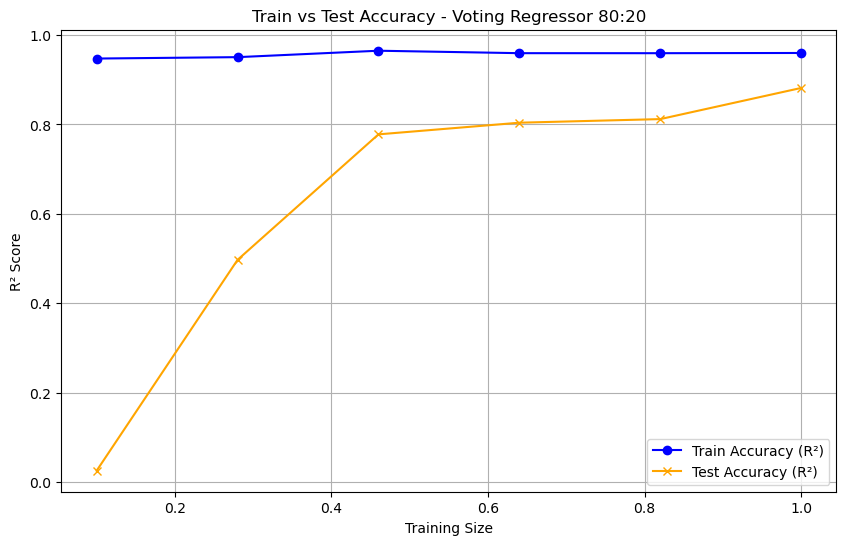

In [31]:
import numpy as np
import matplotlib.pyplot as plt

# Training sizes (misalnya dalam persen data training)
training_sizes_voting2 = np.linspace(0.1, 1.0, 6)

# Menyimpan nilai R² untuk setiap training size
train_accuracies_best_voting2 = []
test_accuracies_best_voting2 = []

for size in training_sizes_voting2:
    # Tentukan jumlah data training sesuai ukuran
    train_size_voting2 = int(size * len(X_train2))
    X_train_subset_voting2 = X_train2[:train_size_voting2]
    y_train_subset_voting2 = y_train2[:train_size_voting2]
    
    # Fit model dengan subset data
    voting_regressor2.fit(X_train_subset_voting2, y_train_subset_voting2)
    
    # Prediksi untuk data training dan testing
    y_train_pred_voting2 = voting_regressor2.predict(X_train_subset_voting2)
    y_test_pred_voting2 = voting_regressor2.predict(X_test2)
    
    # Hitung R² Score
    train_accuracies_best_voting2.append(r2_score(y_train_subset_voting2, y_train_pred_voting2))
    test_accuracies_best_voting2.append(r2_score(y_test2, y_test_pred_voting2))

# Plot Train vs Test Accuracy khusus model terbaik
plt.figure(figsize=(10, 6))
plt.plot(training_sizes_voting2, train_accuracies_best_voting2, 'bo-', label='Train Accuracy (R²)')
plt.plot(training_sizes_voting2, test_accuracies_best_voting2, 'x-', color='orange', label='Test Accuracy (R²)')
plt.xlabel('Training Size')
plt.ylabel('R² Score')
plt.title(f'Train vs Test Accuracy - Voting Regressor 80:20')
plt.grid(True)
plt.legend()
plt.show()


Cross Validation Voting Regressor 2 karena dia lebih tinggi dari voting yang 70:30 jadi ceknya yang paling tinggi aja

In [ ]:
from sklearn.model_selection import cross_val_score

# Model terbaik
# best_model_name = results_df2.iloc[0]['Model']
# best_model = models2[best_model_name]

# Cross-validation
cv_folds = 5  # Jumlah lipatan (folds)
cv_scores = cross_val_score(voting_regressor2, X1, y1, cv=cv_folds, scoring='r2', )

# Rata-rata dan standar deviasi R² Score dari cross-validation
mean_cv_score = np.mean(cv_scores)
std_cv_score = np.std(cv_scores)

# Tampilkan hasil
print(f"Cross-Validation Scores (R²): {cv_scores}")
print(f"Mean R² Score: {mean_cv_score:.4f}")
print(f"Standard Deviation: {std_cv_score:.4f}")


Cross-Validation Scores (R²): [0.60324492 0.78323219 0.58134629 0.41844975 0.67807326]
Mean R² Score: 0.6129
Standard Deviation: 0.1201


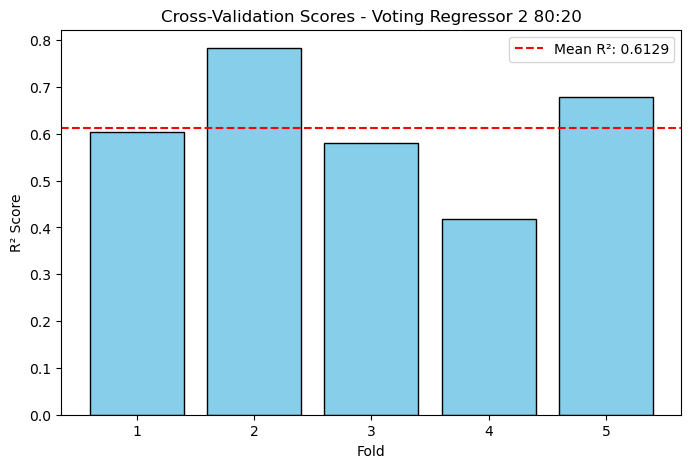

In [35]:
plt.figure(figsize=(8, 5))
plt.bar(range(1, cv_folds + 1), cv_scores, color='skyblue', edgecolor='black')
plt.axhline(y=mean_cv_score, color='red', linestyle='--', label=f"Mean R²: {mean_cv_score:.4f}")
plt.xlabel('Fold')
plt.ylabel('R² Score')
plt.title(f'Cross-Validation Scores - Voting Regressor 2 80:20')
plt.legend()
plt.show()


Hyperparameter tuning voting regressor 2

In [70]:
param_grid = {
    'xgboost__n_estimators': [50, 100, 200],
    'xgboost__max_depth': [3, 5, 7],
    'xgboost__learning_rate': [0.01, 0.1, 0.2],
    # 'xgboost__reg_lambda': [0.01, 0.1, 0.2],
    'ridge__alpha': [0.1, 1.0, 10.0],
    'rf__n_estimators': [50, 100, 200],
    'rf__max_depth': [None, 10, 20],
    'weights': [[3, 2, 1], [2, 1, 3], [1, 3, 2], [1, 2, 3]]
}

In [71]:
from sklearn.model_selection import GridSearchCV

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=voting_regressor2, 
                           param_grid=param_grid, 
                           scoring='r2', 
                           cv=5, 
                           n_jobs=-1)

# Fit the grid search
grid_search.fit(X_train2, y_train2)

GridSearchCV(cv=5,
             estimator=VotingRegressor(estimators=[('xgboost',
                                                    XGBRegressor(base_score=None,
                                                                 booster=None,
                                                                 callbacks=None,
                                                                 colsample_bylevel=None,
                                                                 colsample_bynode=None,
                                                                 colsample_bytree=None,
                                                                 device=None,
                                                                 early_stopping_rounds=None,
                                                                 enable_categorical=False,
                                                                 eval_metric=None,
                                                                 feature_types=None,
                                                                 gamma=None,
                                                                 grow_policy=None,
                                                                 importance_type=None,
                                                                 interactio...
                                                   ('rf',
                                                    RandomForestRegressor(random_state=42))],
                                       n_jobs=-1, weights=[3, 2, 1]),
             n_jobs=-1,
             param_grid={'rf__max_depth': [None, 10, 20],
                         'rf__n_estimators': [50, 100, 200],
                         'ridge__alpha': [0.1, 1.0, 10.0],
                         'weights': [[3, 2, 1], [2, 1, 3], [1, 3, 2],
                                     [1, 2, 3]],
                         'xgboost__learning_rate': [0.01, 0.1, 0.2],
                         'xgboost__max_depth': [3, 5, 7],
                         'xgboost__n_estimators': [50, 100, 200]},
             scoring='r2')

In [72]:
# Retrieve the best model
best_model_vr2 = grid_search.best_estimator_

# Print best parameters and score
print("Best parameters:", grid_search.best_params_)
print("Best score (R2):", grid_search.best_score_)

# Test set evaluation
from sklearn.metrics import r2_score

y_pred_vr2 = best_model_vr2.predict(X_test2)
print("R2 Score on test data:", r2_score(y_test2, y_pred_vr2))

Best parameters: {'rf__max_depth': 10, 'rf__n_estimators': 50, 'ridge__alpha': 0.1, 'weights': [1, 3, 2], 'xgboost__learning_rate': 0.1, 'xgboost__max_depth': 3, 'xgboost__n_estimators': 200}
Best score (R2): 0.6021717455958001
R2 Score on test data: 0.8300477705389683


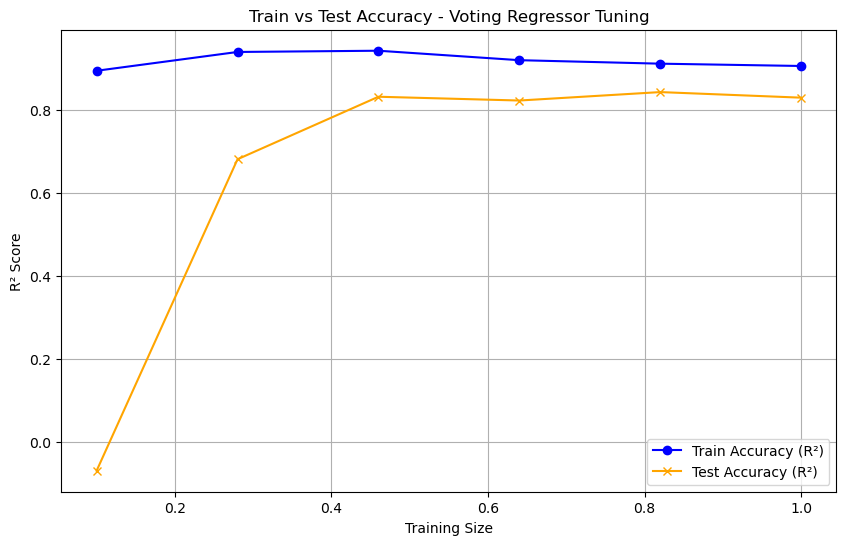

In [73]:
import numpy as np
import matplotlib.pyplot as plt

# Training sizes (misalnya dalam persen data training)
training_sizes = np.linspace(0.1, 1.0, 6)

# Menyimpan nilai R² untuk setiap training size
train_accuracies_best = []
test_accuracies_best = []

for size in training_sizes:
    # Tentukan jumlah data training sesuai ukuran
    train_size = int(size * len(X_train2))
    X_train_subset = X_train2[:train_size]
    y_train_subset = y_train2[:train_size]
    
    # Fit model dengan subset data
    best_model_vr2.fit(X_train_subset, y_train_subset)
    
    # Prediksi untuk data training dan testing
    y_train_pred = best_model_vr2.predict(X_train_subset)
    y_test_pred = best_model_vr2.predict(X_test2)
    
    # Hitung R² Score
    train_accuracies_best.append(r2_score(y_train_subset, y_train_pred))
    test_accuracies_best.append(r2_score(y_test2, y_test_pred))

# Plot Train vs Test Accuracy khusus model terbaik
plt.figure(figsize=(10, 6))
plt.plot(training_sizes, train_accuracies_best, 'bo-', label='Train Accuracy (R²)')
plt.plot(training_sizes, test_accuracies_best, 'x-', color='orange', label='Test Accuracy (R²)')
plt.xlabel('Training Size')
plt.ylabel('R² Score')
plt.title(f'Train vs Test Accuracy - Voting Regressor Tuning')
plt.grid(True)
plt.legend()
plt.show()


In [74]:
# Model dengan parameter default (sebelum tuning)
default_model = VotingRegressor(estimators=[
    ('xgboost', xgb.XGBRegressor(random_state=42)),
    ('ridge', Ridge(random_state=42)),
    ('rf', RandomForestRegressor(random_state=42))
])

default_model.fit(X_train2, y_train2)
y_pred_default = default_model.predict(X_test2)

# Bandingkan dengan model hasil tuning
tuned_model = grid_search.best_estimator_
y_pred_tuned = tuned_model.predict(X_test2)

# Evaluasi skor
from sklearn.metrics import r2_score
print("R2 Score (default):", r2_score(y_test2, y_pred_default))
print("R2 Score (tuned):", r2_score(y_test2, y_pred_tuned))

R2 Score (default): 0.8779235617027977
R2 Score (tuned): 0.8300477705389683


Tuning Pakai Nested Cross Validation

In [78]:
from sklearn.model_selection import KFold, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from sklearn.linear_model import Ridge
from xgboost import XGBRegressor
import numpy as np


In [79]:
# Contoh dataset
from sklearn.model_selection import train_test_split

# Model dasar
xgboost = XGBRegressor(random_state=42)
ridge = Ridge(random_state=42)
rf = RandomForestRegressor(random_state=42)

# Voting Regressor
vr = VotingRegressor(estimators=[
    ('xgboost', xgboost),
    ('ridge', ridge),
    ('rf', rf)
])


In [80]:
param_grid_vr = {
    'xgboost__n_estimators': [50, 100, 150, 200],
    'xgboost__max_depth': [3, 5, 6, 7],
    'xgboost__learning_rate': [0.01, 0.1, 0.2, 0.3],
    'xgboost__reg_lambda': [0.01, 0.1, 0.2, 1.0],
    'ridge__alpha': [0.1, 1.0, 5.0, 10.0],
    'rf__n_estimators': [50, 100, 150, 200],
    'rf__max_depth': [None, 10, 20, 30]
}


In [81]:
# Outer Loop untuk evaluasi akhir
outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Inner Loop untuk tuning hyperparameter
inner_cv = KFold(n_splits=3, shuffle=True, random_state=42)

# GridSearchCV untuk Inner Loop
grid_search_vr = GridSearchCV(estimator=vr,
                           param_grid=param_grid_vr,
                           scoring='r2',
                           cv=inner_cv,
                           n_jobs=-1)

# Nested Cross-Validation
nested_scores = cross_val_score(grid_search_vr, X_train2, y_train2, scoring='r2', cv=outer_cv)

print("Nested CV R2 Scores:", nested_scores)
print("Mean R2 Score:", np.mean(nested_scores))


c:\Users\lenovo\anaconda3\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Nested CV R2 Scores: [0.69121525 0.68264886 0.66502487 0.50563304 0.26053201]
Mean R2 Score: 0.5610108048021253


In [82]:
# Fit model terbaik pada seluruh data train
grid_search_vr.fit(X_train2, y_train2)

# Best model dari GridSearchCV
best_vr = grid_search_vr.best_estimator_

# Evaluasi pada data test
from sklearn.metrics import r2_score

y_pred_vr = best_vr.predict(X_test2)
print("R2 Score on Test Data:", r2_score(y_test2, y_pred_vr))


R2 Score on Test Data: 0.8035174049094073


In [83]:
best_vr

VotingRegressor(estimators=[('xgboost',
                             XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_...
                                          max_cat_threshold=None,
                                          max_cat_to_onehot=None,
                                          max_delta_step=None, max_depth=7,
                                          max_leaves=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          multi_strategy=None, n_estimators=50,
                                          n_jobs=None, num_parallel_tree=None,
                                          random_state=42, ...)),
                            ('ridge', Ridge(alpha=0.1, random_state=42)),
                            ('rf',
                             RandomForestRegressor(n_estimators=50,
                                                   random_state=42))])

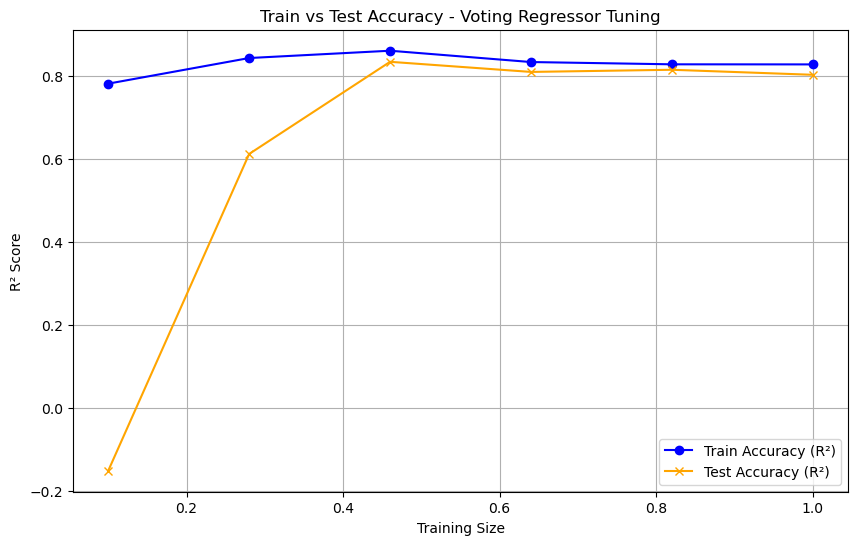

In [84]:
import numpy as np
import matplotlib.pyplot as plt

# Training sizes (misalnya dalam persen data training)
training_sizes = np.linspace(0.1, 1.0, 6)

# Menyimpan nilai R² untuk setiap training size
train_accuracies_best = []
test_accuracies_best = []

for size in training_sizes:
    # Tentukan jumlah data training sesuai ukuran
    train_size = int(size * len(X_train2))
    X_train_subset = X_train2[:train_size]
    y_train_subset = y_train2[:train_size]
    
    # Fit model dengan subset data
    best_vr.fit(X_train_subset, y_train_subset)
    
    # Prediksi untuk data training dan testing
    y_train_pred = best_vr.predict(X_train_subset)
    y_test_pred = best_vr.predict(X_test2)
    
    # Hitung R² Score
    train_accuracies_best.append(r2_score(y_train_subset, y_train_pred))
    test_accuracies_best.append(r2_score(y_test2, y_test_pred))

# Plot Train vs Test Accuracy khusus model terbaik
plt.figure(figsize=(10, 6))
plt.plot(training_sizes, train_accuracies_best, 'bo-', label='Train Accuracy (R²)')
plt.plot(training_sizes, test_accuracies_best, 'x-', color='orange', label='Test Accuracy (R²)')
plt.xlabel('Training Size')
plt.ylabel('R² Score')
plt.title(f'Train vs Test Accuracy - Voting Regressor Tuning')
plt.grid(True)
plt.legend()
plt.show()


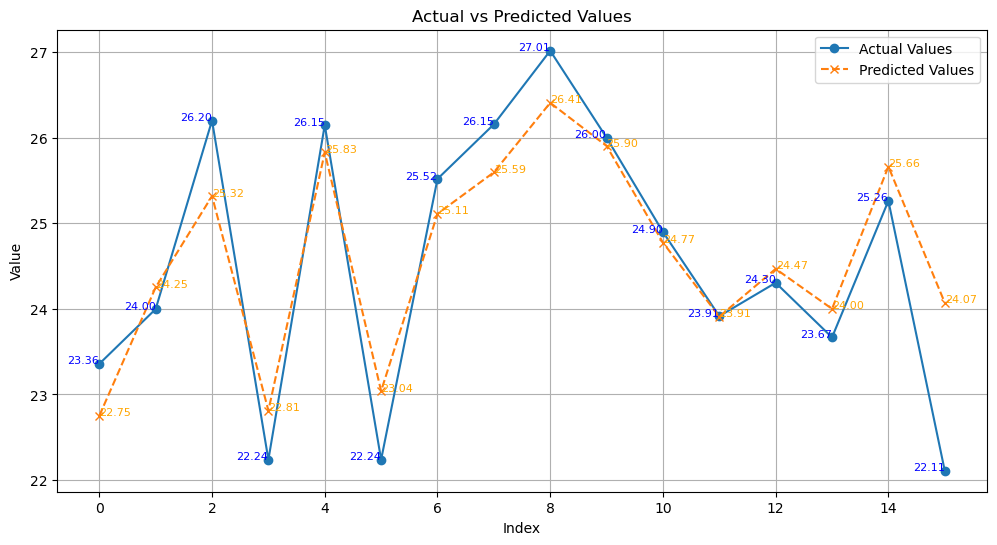

In [85]:
import matplotlib.pyplot as plt
import numpy as np

# Pastikan data berbentuk array (jika tidak, ubah dengan np.array)
y_test_voting2 = np.array(y_test2)  # Nilai aktual
y_pred_voting2 = np.array(y_test_pred)  # Nilai prediksi

# Buat plot
plt.figure(figsize=(12, 6))
plt.plot(range(len(y_test_voting2)), y_test_voting2, label='Actual Values', marker='o', linestyle='-')
plt.plot(range(len(y_pred_voting2)), y_pred_voting2, label='Predicted Values', marker='x', linestyle='--')

# Tambahkan angka di setiap titik
for i, (y_actual, y_predict) in enumerate(zip(y_test_voting2, y_pred_voting2)):
    plt.text(i, y_actual, f'{y_actual:.2f}', fontsize=8, ha='right', color='blue')
    plt.text(i, y_predict, f'{y_predict:.2f}', fontsize=8, ha='left', color='orange')

# Tambahkan label dan judul
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.grid(True)

# Tampilkan plot
plt.show()